# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [1]:
import numpy as np
import os
import sys
import shutil
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

# Used for image processing and manipulations
import cv2

# Used for internal storage
import pickle

# Used for data augmentation
from skimage import exposure
from skimage import util

# Used for dividing the data into training and testing
import pandas as pd
from random import seed
from random import random

from glob import glob

## Object detection imports

Here are the imports from the object detection module.

In [2]:
PATH_TO_ROOT = r'C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/'
PATH_TO_OUTPUT = r'C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/trained_output/'
PATH_TO_API = r'C:/Users/saidz/tensorflow/models/research'

sys.path.append(PATH_TO_API)
sys.path.append(PATH_TO_API + '/object_detection')

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [3]:
PATH_TO_LABELS = r'annotations/label_map.pbtxt'
NUM_CLASSES = 4

os.chdir(PATH_TO_ROOT)

M = "INCEPTION" # Fast labeling, but misses
M = "FRCNN" # More accurate labeling

if (M == "FRCNN"):
    try:
        shutil.rmtree('annotation_pipeline/pretrained/reextracted_frozen_frcnn')
    except OSError as e:
        print ("New frozen file will be generated in pretrained/reextracted_frozen_frcnn.")

    !python C:/Users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py \
        --pipeline_config_path=pretrained/train_config/faster_rcnn_resnet101_coco.config \
        --trained_checkpoint_prefix=training/model.ckpt-1000 \
        --output_directory=trained_output/final_frozen_frcnn/
    PATH_TO_MODEL = PATH_TO_ROOT + r'trained_output/final_frozen_frcnn/frozen_inference_graph.pb'
elif (M == "INCEPTION"):
    try:
        shutil.rmtree('annotation_pipeline/pretrained/reextracted_frozen_inception')
    except OSError as e:
        print ("New frozen file will be generated in pretrained/reextracted_frozen_inception.")
        
    !python c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py \
        --pipeline_config_path=pretrained/annotation_config/ssd_inception_v2_coco.config \
        --trained_checkpoint_prefix=pretrained/ssd_inception_v2_coco_2018_01_28/model.ckpt \
        --output_directory=pretrained/reextracted_frozen_inception/
    PATH_TO_MODEL = PATH_TO_ROOT + r'pretrained/reextracted_frozen_inception/frozen_inference_graph.pb'


New frozen file will be generated in pretrained/reextracted_frozen_frcnn.
Converted 530 variables to const ops.


Instructions for updating:
Please switch to tf.train.get_or_create_global_step
2019-12-09 15:05:21.150305: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\platform\cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-12-09 15:05:32.011082: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\grappler\devices.cc:51] Number of eligible GPUs (core count >= 8): 0
Traceback (most recent call last):
  File "C:/Users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py", line 119, in <module>
    tf.app.run()
  File "C:\Users\saidz\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\platform\app.py", line 48, in run
    _sys.exit(main(_sys.argv[:1] + flags_passthrough))
  File "C:/Users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py", line 115, in main
    FLAGS.output_directory, input_shape)
  File "C:\Users\saidz\tens

In [ ]:
python C:/Users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py --pipeline_config_path=pretrained/train_config/faster_rcnn_resnet101_coco.config --trained_checkpoint_prefix=training/model.ckpt-614 --output_directory=trained_output/final_frozen_frcnn

In [4]:
PATH_TO_MODEL = PATH_TO_ROOT + r'trained_output/final_frozen_frcnn/frozen_inference_graph.pb'

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'red'}, 2: {'id': 2, 'name': 'yellow'}, 3: {'id': 3, 'name': 'green'}, 4: {'id': 4, 'name': '????'}}


In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
print("detection_model.image_tensor: ")
print(detection_graph.get_tensor_by_name('image_tensor:0'), "\n")
print("detection_model.detection_boxes: ")
print(detection_graph.get_tensor_by_name('detection_boxes:0'), "\n")
print("detection_model.detection_scores: ")
print(detection_graph.get_tensor_by_name('detection_scores:0'), "\n")
print("detection_model.detection_classes: ")
print(detection_graph.get_tensor_by_name('detection_classes:0'), "\n")
print("detection_model.num_detections: ")
print(detection_graph.get_tensor_by_name('num_detections:0'), "\n")

detection_model.image_tensor: 
Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8) 

detection_model.detection_boxes: 
Tensor("detection_boxes:0", dtype=float32) 

detection_model.detection_scores: 
Tensor("detection_scores:0", dtype=float32) 

detection_model.detection_classes: 
Tensor("detection_classes:0", dtype=float32) 

detection_model.num_detections: 
Tensor("num_detections:0", dtype=float32) 



In [49]:
PATH_TO_TEST_IMAGES_DIR = 'C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_sim/'
PATH_TO_TEST_IMAGES_DIR = 'annotation_pipeline/raw-images-simulation/'


print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*/*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*/*.jpg'))

PATH_TO_TEST_IMAGES_DIR = 'C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_udacity/'
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))

print("Length of test images:", len(TEST_IMAGE_PATHS))

annotation_pipeline/raw-images-simulation/*/*.jpg
Length of test images: 9


In [50]:
output_dict =[]
rows = len(TEST_IMAGE_PATHS) // 5 + 1
fig = plt.figure(figsize=(12,3*rows))

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for icount in range(0,len(TEST_IMAGE_PATHS),5):
            print('Number {} out of {}, file name: {}'.format(icount, len(TEST_IMAGE_PATHS), TEST_IMAGE_PATHS[icount]))
            image_path = TEST_IMAGE_PATHS[icount]
            image = Image.open(image_path)

            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            color = str(TEST_IMAGE_PATHS[icount]).replace('\\','/').split('/')[-2]

            output_dict.append({'path': str(TEST_IMAGE_PATHS[icount]).replace('\\','/'), 'color': color, \
                                'boxes': boxes, 'scores': scores, 'classes': classes})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)

#             ax = plt.subplot(rows,5,len(output_dict))
#             ax.imshow(image_np)
#             ax.set_title("{}: {}".format(color, len(output_dict[icount]['boxes'])), fontsize=10)
#             ax.axis("off")
                    
# plt.show()

Number 0 out of 9, file name: C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_udacity\left0000.jpg
Number 5 out of 9, file name: C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_udacity\left0528.jpg


<Figure size 864x432 with 0 Axes>

C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_udacity/left0000.jpg :


<Figure size 864x864 with 0 Axes>

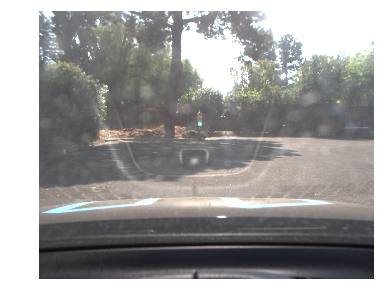

C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_udacity/left0528.jpg :


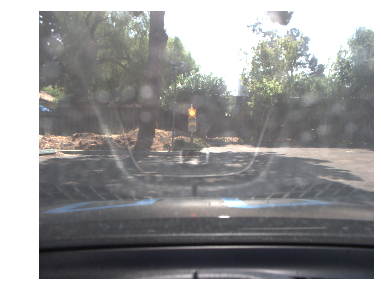

In [51]:
rows = len(output_dict) // 2 + 1
fig = plt.figure(figsize=(12,6*rows))
for i in range(len(output_dict)):
    print(output_dict[i]["path"],":")
    image = Image.open(output_dict[i]["path"])
    image_np = load_image_into_numpy_array(image)

    color = str(TEST_IMAGE_PATHS[icount]).replace('\\','/').split('/')[-2]

    z=list(zip(output_dict[i]["classes"],output_dict[i]["scores"]))
    for j in range(len(z)):
        if (output_dict[i]["scores"][j]>0.2):
            print(z[j])


    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np, output_dict[i]["boxes"], output_dict[i]["classes"], output_dict[i]["scores"],
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=.3,
        line_thickness=6)

        
    plt.figure(figsize=(6,6))
    plt.imshow(image_np)
    plt.axis("off")

    plt.show()
                    